# Тема ВКР - плагин Visual Studio Code для рекомендации NuGet зависимостей на основе машинного обучения
#### В данной работе рассматривается разработка плагина, предназначенного для рекомендации NuGet зависимостей.
#### Актуальность темы заключается в том, что во время разработки ПО приходится тратить значимую часть времени на поиск и установку необходимых библиотек в проект, что отвлекает от основной задачи и мешает сосредоточиться.
#### Целью работы является разработка плагина для Visual Studio Code, предназначенного для рекомендации NuGet зависимостей, чтобы избавить разработчика от рутинных действий по установке и поиску NuGet зависимостей.
#### Для достижения цели были поставлены следующие задачи:
*	Изучить основные алгоритмы обработки естественного языка с применением машинного обучения и методы разработки плагинов для Visual Studio Code
*	Составить методологию по реализации проекта
*	Осуществить сбор данных из открытых источников
*	Реализация модели машинного обучения и её тестирование
*	Создание плагина для Visual Studio Code с использованием разработанной модели машинного обучения


## Сбор данных

In [4]:
import csv
import requests
from bs4 import BeautifulSoup
import json
import time

api_url = 'https://api.github.com/search/repositories'
headers = {'User-Agent': 'MyPyScrapper/1.0'}
repo_url = "https://api.github.com/repos/{}"
data_file = "repos_data.csv"

In [5]:
# случай, если описание проекта не влазит полностью
def get_full_description(repo_name):
    # Send a GET request to the API endpoint
    response = requests.get(f'https://api.github.com/repos/{repo_name}')

    # Get the response content
    content = response.content.decode('utf-8')
    description = json.loads(content)['description']
    return description

def get_repo_data(url, headers, params):
    response = requests.get(url, headers=headers, params=params)

    # Check the response status code
    if response.status_code!= 200:
        print(f"Error {response.status_code}: {response.reason}")
        return []

    # Check the response content
    content = response.content.decode('utf-8')
    try:
        data = json.loads(content)
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        return []

    repos_collection = data['items'] # Extract the items array
    valid_repos = []
    for repo in repos_collection:
        repo_name = repo['full_name']
        repo_description = repo['description']

        if repo_description != "" and repo_description is not None:
            # описание не влазит полностью
            # поэтому дополнительно парсим страницу с репозиторием
            if len(repo_description) > 10 and repo_description.endswith('...'):
                repo_description = get_full_description(repo_name)
                print(f"делаем дополнительный парсинг к репозиторию {repo_name}")

            valid_repos.append([repo_name, repo_description])

    return valid_repos


def save_to_csv(data, file):
    fieldnames = ["Repository", "Description"]
    with open(file, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        if csvfile.tell() == 0:
            writer.writeheader()

        for row in data:
            writer.writerow({"Repository": row[0], "Description": row[1]})


In [ ]:
year = 2024
print(f"YEAR {year}")
for page in range(1, 5+1):
    params = {'q': f'created:{year}-01-01..{year}-12-31 language:C# is:public topics:<1', 'per_page': 200, 'page': page}
    print(f"Scrapping page {page}...")
    repos_data = get_repo_data(url=api_url, headers=headers, params=params)
    print(f"data: {repos_data}")

    if len(repos_data) > 0:
        save_to_csv(repos_data, data_file) # Сохранение элементов в csv формат

print()

YEAR 2024
Scrapping page 1...
data: [['ExOK/Celeste64', 'A game made by the Celeste developers in a week(ish, closer to 2)'], ['FalconForceTeam/SOAPHound', 'SOAPHound is a custom-developed .NET data collector tool which can be used to enumerate Active Directory environments via the Active Directory Web Services (ADWS) protocol.'], ['unity3d-jp/Project_TCC', 'TCC stands for Tiny Character Controller. TCC is the best way to make your own game. This repository contains all packages and examples for TCC projects.'], ['FireCubeStudios/StartStrikesBack', 'Fixed Windows 11 start menu by FireCube'], ['vitoplantamura/HackerNewsRemovals', 'List of stories removed from the Hacker News Front Page, updated in real time.'], ['DeEpinGh0st/WindowsBaselineAssistant', 'Windows安全基线核查加固助手'], ['INotGreen/SharpThief', '一键提取exe的图标、嵌入图标、资源信息、版本信息、修改时间、数字签名，降低程序熵值'], ['nicsure/QuanshengDock', 'Allows the Quansheng UV-K5 radio to be controlled by a PC.'], ['vercidium-patreon/meshing', 'Greedy meshing algorithm 

## Предобработка текстового описания репозиториев

> C горем пополам собрал датасет из 8247 строк, cостоящий из 3-ёх типов запросов с 2019 по 2024 года

**`При применении методов машинного поиска для рекомендации NuGet зависимостей на основе текстовых описаний проектов, необходимо применять ту же самую предобработку к текстовому описанию, которое вводит пользователь, что и к данным в обучающем наборе, чтобы обеспечить согласованность данных и улучшить качество рекомендаций.`**

Далее последовательность действий следующая:
* Убрать специальные знаки, эмоджи
* Там куча разных языков миксованных с английским, нужно оставить чисто английский
* лемматизация/стемминг
* word embeddings/sentences embeddings



Перед векторизацией текста необходимо провести его предобработку, чтобы подготовить для обучения модели. Шаги, которые нужно выполнить:
1. Токенизация - процесс разбиения текста на небольшие фрагменты, называемые токенами. Токены могут быть отдельными словами, символами, фразами или другими единицами текста в зависимости от задачи и контекста.
2. Удаление стоп-слов - удаление слов, которые не несут значимой информации, таких как предлоги, артикли и т. д.
Нормализация - приведение текста к стандартному виду, например, замена всех букв на нижний регистр.
3. Лематизация - приведение слов к их словарной форме, например, глаголы в инфинитиве.
4. Стемминг - сокращение слова до его основы, удаляя окончания и суффиксы.
5. Расширение контекста - добавление слов вокруг целевого слова, чтобы увеличить контекст.
6. Фильтрация - удаление редких и шумных слов, которые могут ухудшить качество модели.
7. Разметка данных - разделение текста на тренировочную, тестовую и валидационную выборки.

>[Полезная статья с примером пайплайна для препроцессинга](https://habr.com/ru/articles/738176/) - это перевод, есть небольшие косяки, чекнуть комментарий к статье

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gc
%matplotlib inline

import sys
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 100 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [33]:
# Load the CSV dataset
data = pd.read_csv("/content/repos_data.csv")
data.drop_duplicates()
data.dropna()
data

,Repository,Description
0,microsoft/PowerToys,Windows system utilities to maximize productivity
1,2dust/v2rayN,"A GUI client for Windows, support Xray core an..."
2,files-community/Files,Building the best file manager for Windows
3,huiyadanli/RevokeMsgPatcher,:trollface: A hex editor for WeChat/QQ/TIM - P...
4,netchx/netch,A simple proxy client
...,...,...
8242,fgilde/AuralizeBlazor,AuralizeBlazor is a wrapper component for audi...
8243,AcK77/TTGames-Explorer-Rebirth,TTGames modding tool
8244,mhdbouk/multitenantdemo,Source code for the YouTube video `Is Your .NE...
8245,CrazyZhang666/MarneTools,战地1马恩工具箱


In [8]:
print(data.isna().sum())
print()
print(data.isnull().sum())

Repository     0
Description    0
dtype: int64

Repository     0
Description    0
dtype: int64


### Очистка мусора, конвертация эмоджи

> Есть описания состоящие из непонятных мне иероглифов, после обработки описание становится пустым - с этим нужно что-то делать (либо терять данные - удалять, либо запариться и переводить на английский, но могут появиться неточности перевода и появится шум...)

In [ ]:
%pip install re
%pip install nltk
%pip install unicodedata
%pip install contractions
%pip install inflect
%pip install emoji

import re
import nltk
import emoji
import unicodedata
import contractions
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

Разбиение на пробелы может привести к тому, что то, что следует рассматривать как один токен, может быть разбито на два, как в случае с некоторыми именами собственными (например, Сан-Франциско или Нью-Йорк) или заимствованными иностранными фразами (например, laissez faire).

**Токенизация** также может удалить знаки препинания, упрощая путь к правильной сегментации слов, но также потенциально вызывая другие сложности. В случае точек, которые следуют за аббревиатурой (например, dr.), точка после этой аббревиатуры должна рассматриваться как часть того же токена и не удаляться.

Процесс токенизации может быть особенно проблематичным при работе с биомедицинскими текстами, которые содержат много дефисов, скобок и других знаков препинания.


In [10]:
# Функция для очистки текста
def clean_text(input_text):

    # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
    clean_text = re.sub('<[^<]+?>', '', input_text)

    # URL и ссылки: далее - удаляем из текста все URL и ссылки
    clean_text = re.sub(r'http\S+', '', clean_text)

    # Эмоджи и эмотиконы: удаляем их нафиг, это кринж какой-то бессмысленный, только шума добавят
    clean_text = remove_emojis(clean_text)

    # Приводим все входные данные к нижнему регистру
    clean_text = clean_text.lower()

    # Убираем все пробелы
    # Так как все данные теперь представлены словами - удалим пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

    # Преобразование символов с диакритическими знаками к ASCII-символам: используем функцию normalize из модуля unicodedata и преобразуем символы с диакритическими знаками к ASCII-символам
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Разворачиваем сокращения: текст часто содержит конструкции вроде "don't" или "won't", поэтому развернём подобные сокращения
    clean_text = contractions.fix(clean_text)

    # Специальные случаи для языков программирования
    clean_text = re.sub(r'c\#', 'csharp', clean_text)
    clean_text = re.sub(r'c\+\+', 'cpp', clean_text)

    # Убираем специальные символы: избавляемся от всего, что не является "словами"
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)

    # Записываем числа прописью: 100 превращается в "сто" (для компьютера)
    temp = inflect.engine()
    words = []
    for word in clean_text.split():
        if word.isdigit():
            words.append(temp.number_to_words(word))
        else:
            words.append(word)
    clean_text = ' '.join(words)

    # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)

    # Add full-stop to end of sentences
    clean_text = re.sub('([a-z])\.([A-Z])', r'\1. \2', clean_text)

    # Знаки препинания: далее - удаляем из текста все знаки препинания
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    # И наконец - возвращаем очищенный текст
    return clean_text

# Функция для преобразования эмоджи в слова
def emojis_to_txt(text):

    # Модуль emoji: преобразование эмоджи в их словесные описания
    clean_text = emoji.demojize(text, delimiters=(" ", " "))

    # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
    clean_text = clean_text.replace(":", "").replace("_", " ")

    return clean_text

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U00010000-\U0010FFFF"  # Unicode characters beyond the Basic Multilingual Plane
        "\u200d"  # Zero-width joiner
        "\u2640-\u2642"  # Male and female signs
        "\u2600-\u26FF"  # Miscellaneous symbols
        "\u2700-\u27BF"  # Dingbats
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [37]:
test_with_emojis = "😊 This is a sample 😊text witgh an emoji 😊 [blablabla] (^🧩) :trollface:"
text_without_emojis = remove_emojis(test_with_emojis)
print(text_without_emojis)

 This is a sample text witgh an emoji  [blablabla] (^) :trollface:


###Кластеризация данных для удаления из них «шума» и шаблонных формулировок


> Пока что не набрал список шаблонных формулировок, нужно будет вручную глянуть датасет и составить список

> Могут быть проблемы с репозиториями, где короткое описание в 1 предложение. Суть в том, что там кластеризация бесполезна -> поэтому думаю надо применить PCA ко всему датасету (а не по-отдельности к каждому описанию) ИЛИ вовсе не применять кластеризацию



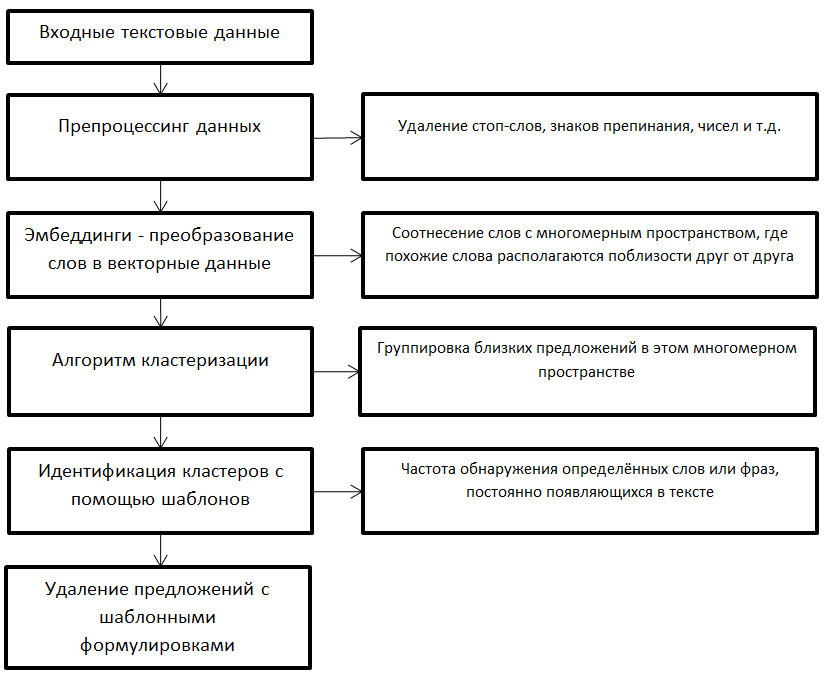

In [ ]:
import re
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def remove_noise_boilerplate(input_text, min_cluster_size=1, num_clusters=5, max_noise_ratio=0.3):

    # Sentence split: To identify boilerplate/noise we will first need to separate sentences to find similarity
    sentences = re.split('\. |\? |\! |\n', input_text)

    # Convert sentences to a matrix of word embeddings
    embeddings_matrix = text_vectorize(sentences)

    # KMeans Clustering: Cluster the sentences to bring similar embeddings together
    kmeans_model = KMeans(n_clusters=num_clusters)
    kmeans_model.fit(embeddings_matrix)
    model_labels = kmeans_model.labels_
    model_centroids = kmeans_model.cluster_centers_

    # Individual cluster size
    cluster_sizes = np.bincount(model_labels)

    # Identify clusters with noise and boilerplate language
    is_noise = np.zeros(num_clusters, dtype=bool)
    for i, centroid in enumerate(model_centroids):
        if cluster_sizes[i] < min_cluster_size:
            # We should ignore clusters with fewer sentences than min_cluster_size threshold
            continue
        distances = np.linalg.norm(embeddings_matrix[model_labels == i] - centroid, axis=1)
        median_distance = np.median(distances)
        if np.count_nonzero(distances > median_distance) / cluster_sizes[i] > max_noise_ratio:
            is_noise[i] = True

    # Remove: Sentences that are in the noise bucket, we remove them (boilerplate)
    filtered_sentences = []
    for i, sentence in enumerate(sentences):
        if not is_noise[model_labels[i]]:
            filtered_sentences.append(sentence)

    # Bring the sentence together
    filtered_text = ' '.join(filtered_sentences)

    return filtered_text

# тут нужно будет много чего нашаманить c n-граммами
def text_vectorize(input_text):

    vectorizer = CountVectorizer()

    # Использование vectorizer.fit для преобразования текста в матрицу частоты употребления слов
    counts_matrix = vectorizer.fit_transform(input_text)

    # Преобразуем полученную матрицу в плотную матрицу
    dense_matrix = counts_matrix.todense()

    # Возврат плотной матрицы в виде массива numpy
    return np.array(dense_matrix)

### Лемматизация и Частеречная разметка текста

In [ ]:
# Подготовка к частеречной разметке текста путём установки библиотеки Spacy, загрузки perceptron_tagger и модуля Spacy en
%pip install spacy
nltk.download('averaged_perceptron_tagger')
!python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load('en_core_web_sm')
lemmatize_exceptions = ['ios', 'mmorts']

In [39]:
def lemmatize_and_postag(input_text):

    doc = nlp(input_text)
    lemmatize_output = []

    # Iterate over each token in the document
    for token in doc:
        if token.text in lemmatize_exceptions:
            lemmatize_output.append(token.text + '_' + token.pos_)
        else:
            # Append the token lemma and its POS tag to the tagged_output list
            lemmatize_output.append(token.lemma_ + '_' + token.pos_)

    # Join the tagged_output list into a single string
    lemmatize_output_str = ' '.join(lemmatize_output)

    return lemmatize_output_str

### Лемматизация ✈ СТАРЫЙ ВАРИАНТ



In [ ]:
def lemmatize_and_vectorize(tagged_text):

    # Convert the tagged text to a string
    text = " ".join([word.split("_")[0] for word in tagged_text.split()])

    # Apply the Spacy pipeline to the text
    doc = nlp(text)

    vector_list = []

    # Iterate over each token in the Spacy document
    for token in doc:
        lemma = token.lemma_

        # Get the part-of-speech tag for the token
        pos = token.pos_

        if pos == "VERB":
            vec = token.vector
        else:
            vec = token.vector + nlp(pos).vector

        vector_list.append(vec)

    vector_array = np.array(vector_list)

    return vector_array

### Собираем все вместе и обрабатываем

In [40]:
def preprocesse(input_text):
    clear_text = clean_text(input_text)
    #print("\nОчистка мусора, конвертация эмоджи:\n", clear_text)

    tagged_output = lemmatize_and_postag(clear_text)
    #print("\nЧастеречная разметка и лемматизация:\n", tagged_output)

    return tagged_output

In [41]:
data.isna().sum()

Repository     0
Description    0
dtype: int64

In [42]:
data.Description = data.Description.apply(preprocesse)

In [43]:
data.to_csv("clean_data.csv", index=False, columns=["Repository", "Description"])

In [54]:
data.isna().sum()

Repository     0
Description    0
dtype: int64

In [44]:
clean_data = pd.read_csv("/content/clean_data.csv")
clean_data

,Repository,Description
0,microsoft/PowerToys,window_NOUN system_NOUN utility_NOUN maximize_...
1,2dust/v2rayN,gui_PROPN client_PROPN window_VERB support_PRO...
2,files-community/Files,build_VERB good_ADJ file_NOUN manager_NOUN win...
3,huiyadanli/RevokeMsgPatcher,trollface_VERB hex_PROPN editor_NOUN wechatqqt...
4,netchx/netch,simple_ADJ proxy_ADJ client_NOUN
...,...,...
8242,fgilde/AuralizeBlazor,auralizeblazor_PROPN wrapper_PROPN component_N...
8243,AcK77/TTGames-Explorer-Rebirth,ttgame_NOUN modding_NOUN tool_NOUN
8244,mhdbouk/multitenantdemo,source_NOUN code_PROPN youtube_NOUN video_NOUN...
8245,CrazyZhang666/MarneTools,one_NUM


In [55]:
clean_data.isna().sum()

Repository       0
Description    109
dtype: int64

In [60]:
clean_data = clean_data.dropna()
clean_data.shape

(8138, 2)

In [62]:
clean_data.to_csv("preprocessed_txtdata.csv", index=False, columns=["Repository", "Description"])

## Векторизация с word2vec подобными алоритмами

In [63]:
data = pd.read_csv("/content/preprocessed_txtdata.csv")
data

,Repository,Description
0,microsoft/PowerToys,window_NOUN system_NOUN utility_NOUN maximize_...
1,2dust/v2rayN,gui_PROPN client_PROPN window_VERB support_PRO...
2,files-community/Files,build_VERB good_ADJ file_NOUN manager_NOUN win...
3,huiyadanli/RevokeMsgPatcher,trollface_VERB hex_PROPN editor_NOUN wechatqqt...
4,netchx/netch,simple_ADJ proxy_ADJ client_NOUN
...,...,...
8133,fgilde/AuralizeBlazor,auralizeblazor_PROPN wrapper_PROPN component_N...
8134,AcK77/TTGames-Explorer-Rebirth,ttgame_NOUN modding_NOUN tool_NOUN
8135,mhdbouk/multitenantdemo,source_NOUN code_PROPN youtube_NOUN video_NOUN...
8136,CrazyZhang666/MarneTools,one_NUM
